In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import ParameterGrid
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


In [24]:
# ==== Load and Prepare Data ====
samples = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_dataframe_proc.csv')
tests = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_tests_proc.csv')

X_train = samples.iloc[:, :-1]
y_train = samples.iloc[:, -1]
X_test = tests.iloc[:, :-1]
y_test = tests.iloc[:, -1]

# Upsample
df = pd.concat([X_train, y_train], axis=1)
normal = df[df['Label'] == 0]
ddos = df[df['Label'] == 1]
normal_upsampled = resample(normal, replace=True, n_samples=len(ddos), random_state=27)
upsampled = pd.concat([normal_upsampled, ddos])
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

# Normalize
scaler = MinMaxScaler((-1, 1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Format for CNN
def format_3d(X):
    return np.reshape(np.array(X), (X.shape[0], X.shape[1], 1))

X_train_3d = format_3d(X_train)
X_test_3d = format_3d(X_test)

# ==== Define CNN Model ====
def CNN_model(input_size):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_size, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [25]:
# ==== Evaluation Function ====
def full_evaluation(model, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate):
    start_time = time.time()
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    train_time = time.time() - start_time

    # Dự đoán xác suất (dùng để tính ROC)
    y_prob = model.predict(X_test).flatten()

    # Dự đoán nhị phân (dùng để tính Accuracy, F1, ...)
    y_pred = (y_prob > 0.5).astype(int)

    # Detection rates
    true_normal = (y_test == 0)
    true_attack = (y_test == 1)
    normal_detect_rate = (y_pred[true_normal] == 0).sum() / true_normal.sum()
    attack_detect_rate = (y_pred[true_attack] == 1).sum() / true_attack.sum()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # ROC Curve and AUC (dùng xác suất chứ không dùng nhị phân)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    return {
        'Model': 'CNN',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Normal_Detect_Rate': normal_detect_rate,
        'Atk_Detect_Rate': attack_detect_rate,
        'Training_Time': train_time,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'Confusion_Matrix': cm.tolist(),
        'ROC_FPR': fpr.tolist(),
        'ROC_TPR': tpr.tolist(),
        'ROC_AUC': roc_auc
    }

# ==== Grid Search ==== 
param_grid = {
    'epochs': [5, 10],
    'batch_size': [64, 128],
    'learning_rate': [0.001, 0.0005]
} 


results = []
for params in ParameterGrid(param_grid):
    print(f"Training CNN with params: {params}")
    model = CNN_model(X_train.shape[1])
    result = full_evaluation(
        model, X_train_3d, y_train,
        X_test_3d, y_test,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate']
    )
    results.append(result)

Training CNN with params: {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 8s 766us/step
Training CNN with params: {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 8s 728us/step
Training CNN with params: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 8s 779us/step
Training CNN with params: {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 9s 866us/step
Training CNN with params: {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Training CNN with params: {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Training CNN with params: {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Training CNN with params: {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [26]:
# ==== Save All Results (excluding ROC) ==== 
df_results_cnn = pd.DataFrame([
    {k: v for k, v in res.items() if k not in ['ROC_FPR', 'ROC_TPR']} for res in results
])

df_results_cnn.to_csv(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\CNN\cnn_gridsearch_results.csv', index=False)

# ==== Save Best Model Result ==== 
best_index_cnn = df_results_cnn['Accuracy'].idxmax()
best_model_result_cnn = results[best_index_cnn]  # Lấy bản đầy đủ để có ROC
best_model_df_cnn = pd.DataFrame([{
    k: v for k, v in best_model_result_cnn.items() if k not in ['ROC_FPR', 'ROC_TPR']
}])

print("\nBest Hyperparameters (CNN - Highest Accuracy):")
for param in best_model_df_cnn.columns:
    print(f"{param}: {best_model_df_cnn[param][0]}")

best_model_df_cnn.to_csv(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\CNN\cnn_best_results.csv', index=False)

# ==== Save ROC for Best Model ==== 
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\CNN\best_model_roc_fpr.npy', np.array(best_model_result_cnn['ROC_FPR']))
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\CNN\best_model_roc_tpr.npy', np.array(best_model_result_cnn['ROC_TPR']))
np.save(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\CNN\best_model_roc_auc.npy', best_model_result_cnn['ROC_AUC'])


Best Hyperparameters (CNN - Highest Accuracy):
Model: CNN
Accuracy: 0.9991164165130636
Precision: 0.9995084321443243
Recall: 0.9994312297024489
F1-Score: 0.9994698294325419
Normal_Detect_Rate: 0.997542350566137
Atk_Detect_Rate: 0.9994312297024489
Training_Time: 98.95407629013062
epochs: 5
batch_size: 64
learning_rate: 0.001
Confusion_Matrix: [[56825, 140], [162, 284663]]
ROC_AUC: 0.9998773653548765


In [37]:
# Read the results into a DataFrame (for plotting purposes only)
grid_df = pd.read_csv(r"cnn_gridsearch_results.csv")

In [40]:
grid_df = pd.DataFrame(grid_df)
print("==== Grid Search Results for CNN ====")
grid_df

==== Grid Search Results for CNN ====


,Accuracy,Precision,Recall,F1-Score,Normal_Detect_Rate,Atk_Detect_Rate,Training_Time,epochs,batch_size,learning_rate,Confusion_Matrix,ROC_AUC
0,0.999116,0.999508,0.999431,0.999470,0.997542,0.999431,98.954076,5,64,0.0010,"[[56825, 140], [162, 284663]]",0.999877
1,0.993906,0.996303,0.996384,0.996344,0.981515,0.996384,90.598364,5,64,0.0005,"[[55912, 1053], [1030, 283795]]",0.999648
2,0.999067,0.999407,0.999473,0.999440,0.997033,0.999473,206.143512,10,64,0.0010,"[[56796, 169], [150, 284675]]",0.999896
3,0.994789,0.994124,0.999656,0.996882,0.970456,0.999656,225.312503,10,64,0.0005,"[[55282, 1683], [98, 284727]]",0.999893
4,0.994801,0.995005,0.998775,0.996886,0.974932,0.998775,106.168083,5,128,0.0010,"[[55537, 1428], [349, 284476]]",0.999764
5,0.994347,0.993586,0.999670,0.996619,0.967735,0.999670,71.392673,5,128,0.0005,"[[55127, 1838], [94, 284731]]",0.999784
6,0.994795,0.995765,0.997999,0.996881,0.978776,0.997999,122.204429,10,128,0.0010,"[[55756, 1209], [570, 284255]]",0.999744
7,0.995450,0.994885,0.999681,0.997277,0.974300,0.999681,124.836064,10,128,0.0005,"[[55501, 1464], [91, 284734]]",0.999717


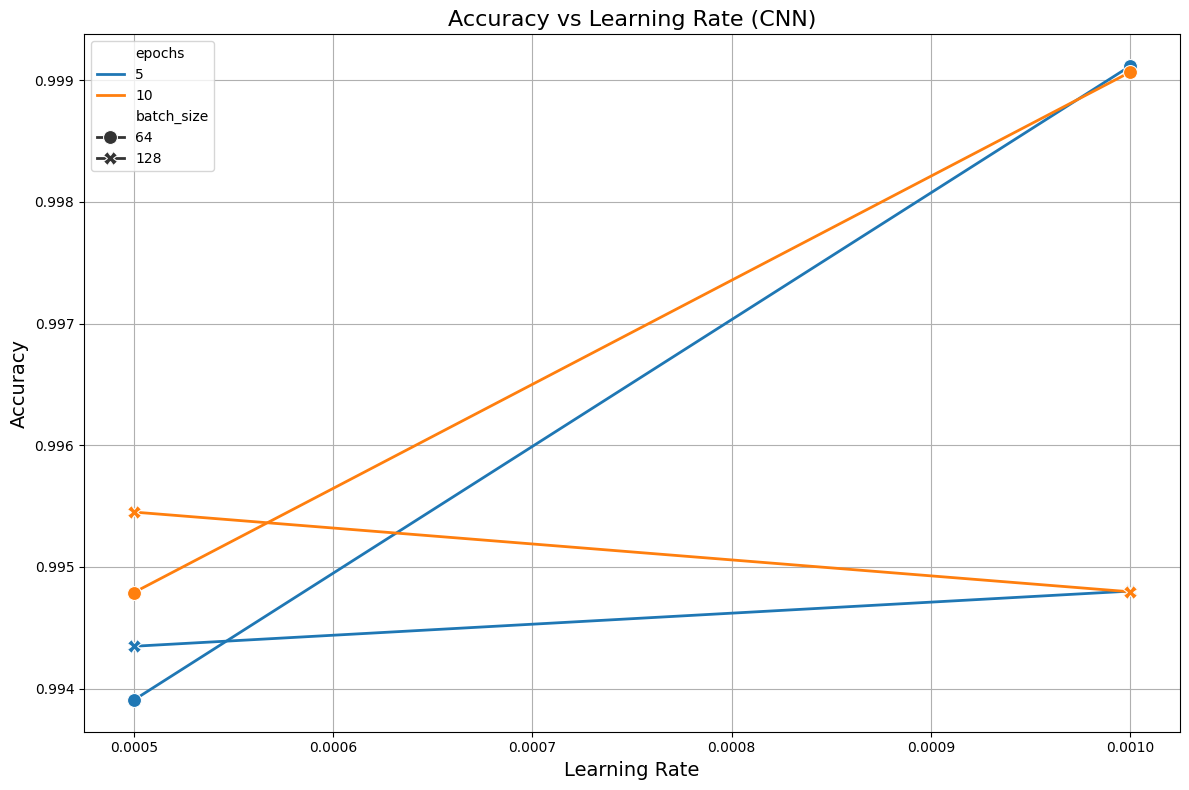

In [14]:
plt.figure(figsize=(12, 8))

# Plot Accuracy vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Accuracy',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',  # Different palette for Accuracy
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Adding title and labels for Accuracy plot
plt.title("Accuracy vs Learning Rate (CNN)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Adjust grid and layout for Accuracy plot
plt.grid(True)
plt.tight_layout()

# Show the Accuracy plot
plt.show()

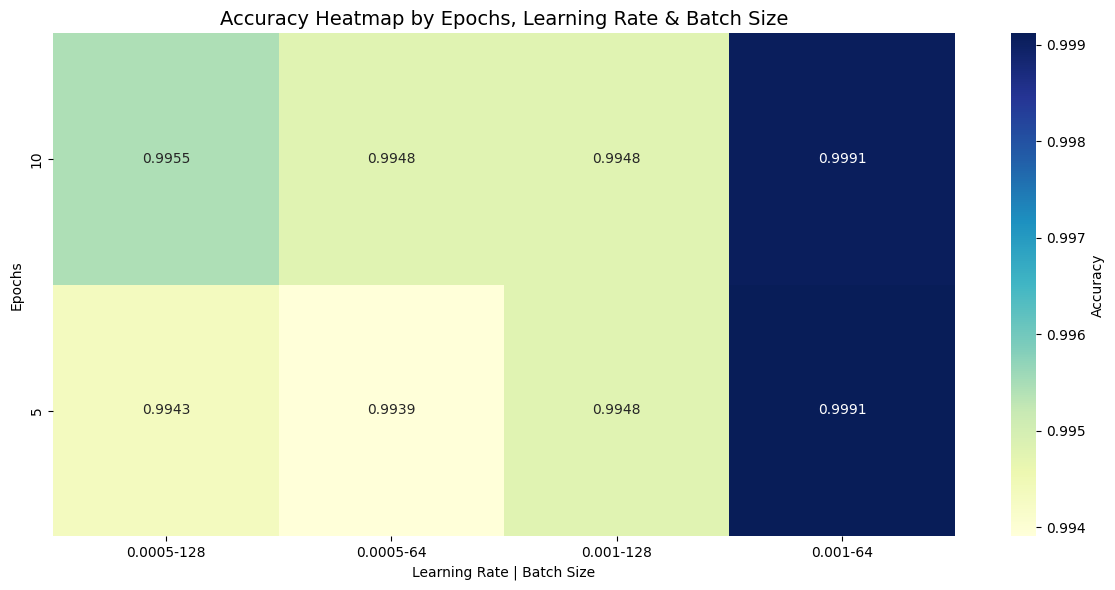

In [33]:
grid_df['learning_rate'] = grid_df['learning_rate'].astype(str)
grid_df['batch_size'] = grid_df['batch_size'].astype(str)

# Create a pivot table with MultiIndex columns: (learning_rate, batch_size)
heatmap_data = grid_df.pivot_table(
    index='epochs',
    columns=['learning_rate', 'batch_size'],
    values='Accuracy',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Accuracy'}
)

plt.title("Accuracy Heatmap by Epochs, Learning Rate & Batch Size", fontsize=14)
plt.xlabel("Learning Rate | Batch Size")
plt.ylabel("Epochs")
plt.tight_layout()
plt.show()

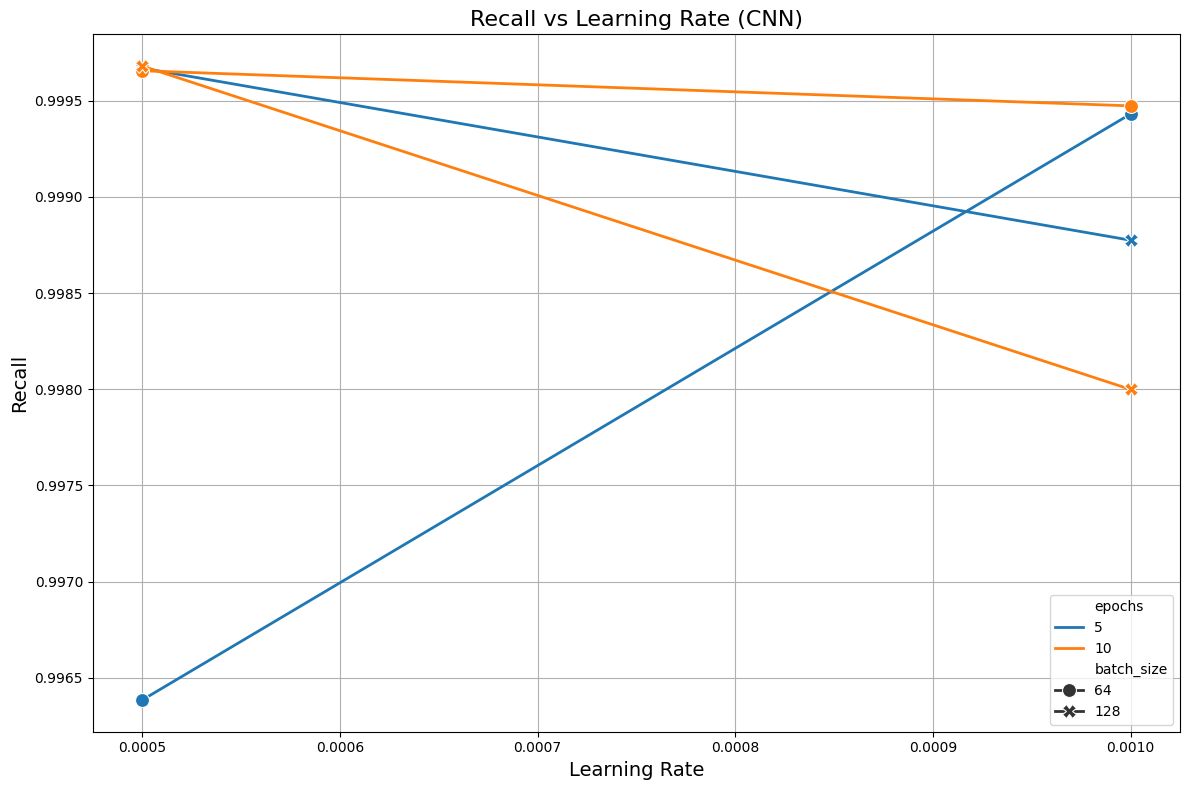

In [12]:
plt.figure(figsize=(12, 8))

# Plot Recall vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Recall',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Add title and labels
plt.title("Recall vs Learning Rate (CNN)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Recall", fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

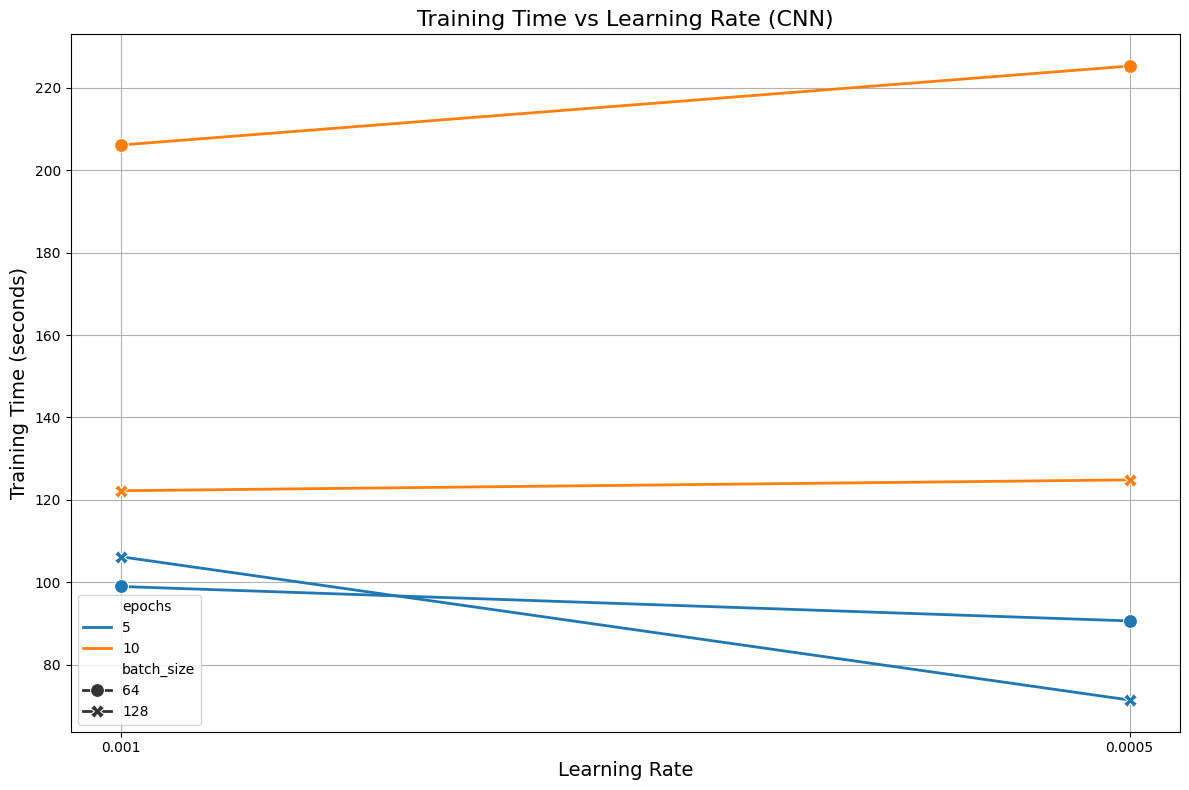

In [24]:
plt.figure(figsize=(12, 8))

# Plot Training Time vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Training_Time',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Add title and labels
plt.title("Training Time vs Learning Rate (CNN)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Training Time (seconds)", fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

BEST MODEL

In [25]:
best_model = grid_df.loc[grid_df['Accuracy'].idxmax()]
print("Best Model Parameters:")
print(best_model)

Best Model Parameters:
Model                                           CNN
Accuracy                                   0.999116
Precision                                  0.999508
Recall                                     0.999431
F1-Score                                    0.99947
Normal_Detect_Rate                         0.997542
Atk_Detect_Rate                            0.999431
Training_Time                             98.954076
epochs                                            5
batch_size                                       64
learning_rate                                 0.001
Confusion_Matrix      [[56825, 140], [162, 284663]]
ROC_AUC                                    0.999877
group                               bs=64, lr=0.001
lr_bs                                    0.001 | 64
combo                         LR=0.001\nBS=64\nEP=5
Name: 0, dtype: object


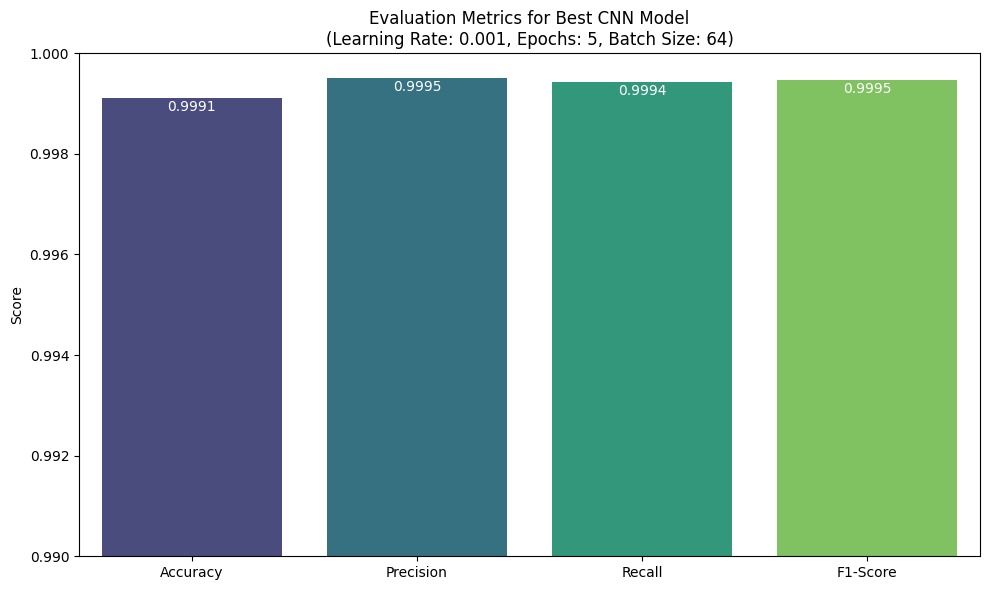

In [28]:
# Prepare evaluation metrics for plotting (CNN)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [best_model['Accuracy'], best_model['Precision'], best_model['Recall'], best_model['F1-Score']]

# Plot the evaluation metrics as a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, hue=metrics, palette='viridis', legend=False)

# Add labels inside the bars, closer to the top
for i, value in enumerate(values):
    plt.text(i, value - 0.00005 , f'{value:.4f}', ha='center', va='top', color='white')

# Set the y-axis to start from 0.99
plt.ylim(0.99, 1.0)

# Add plot title and labels — updated for CNN
plt.title(
    f"Evaluation Metrics for Best CNN Model\n"
    f"(Learning Rate: {best_model['learning_rate']}, Epochs: {best_model['epochs']}, Batch Size: {best_model['batch_size']})"
)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

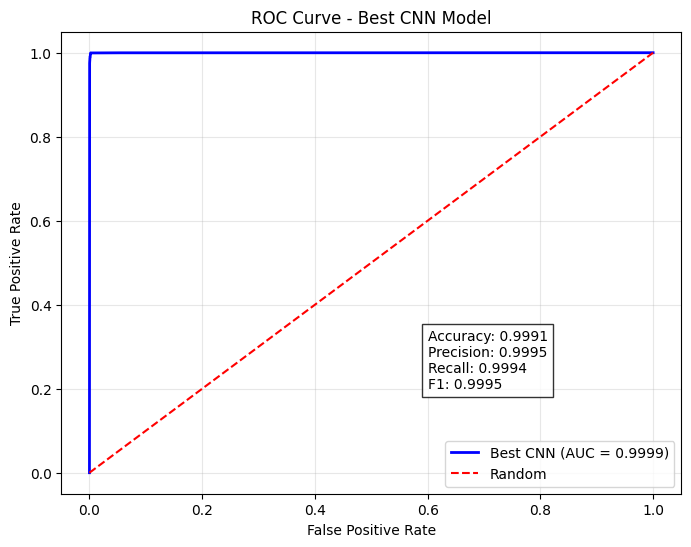

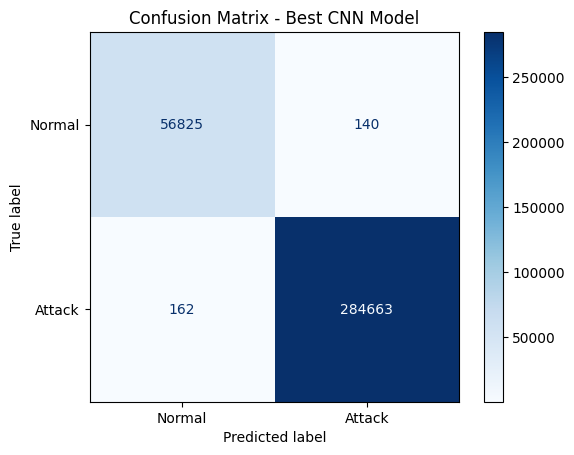

In [ ]:
# ==== Load ROC  ====
best_model_roc_fpr_cnn = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\CNN\best_model_roc_fpr.npy', allow_pickle=True)
best_model_roc_tpr_cnn = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\CNN\best_model_roc_tpr.npy', allow_pickle=True)
best_model_roc_auc_cnn = np.load(r'D:\Nam3\HK2\ATBM\DDOS\Notebooks\CNN\best_model_roc_auc.npy', allow_pickle=True)

# ==== ROC Curve====
plt.figure(figsize=(8, 6))
plt.plot(best_model_roc_fpr_cnn, best_model_roc_tpr_cnn, 'b-', linewidth=2, label=f'Best CNN (AUC = {best_model_roc_auc_cnn:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best CNN Model')
plt.legend()
plt.grid(alpha=0.3)


plt.text(0.6, 0.2, f'Accuracy: {best_model_df_cnn["Accuracy"].values[0]:.4f}\n'
                   f'Precision: {best_model_df_cnn["Precision"].values[0]:.4f}\n'
                   f'Recall: {best_model_df_cnn["Recall"].values[0]:.4f}\n'
                   f'F1: {best_model_df_cnn["F1-Score"].values[0]:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# ==== Confusion Matrix  CNN ====
cm_cnn = np.array(best_model_result_cnn['Confusion_Matrix'])  
if cm_cnn.ndim == 3:  
    cm_cnn = cm_cnn[0]
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=['Normal', 'Attack'])
disp_cnn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best CNN Model')
plt.grid(False)
plt.show()